# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;">Previsões Acionárias Baseadas em Indicadores</p>

![Previsões Acionárias Baseadas em Indicadores](https://github.com/jeffev/analise-mercado-financeiro-brasil/blob/main/imagens/prevendo_acoes.jpeg?raw=true)

# **Introdução**

- **Definição do Problema:**

O mercado de ações é um ambiente complexo e dinâmico, onde o valor das ações pode flutuar significativamente devido a diversos fatores. A análise de ações é a prática de avaliar empresas e determinar o valor intrínseco de suas ações. Essa avaliação é crucial para tomar decisões de investimento informadas e potencialmente lucrativas.


- **Objetivo:**

Este projeto tem como objetivo desenvolver um modelo para prever o valor de ações utilizando análise de indicadores financeiros. O modelo será treinado em um conjunto de dados históricos de indicadores financeiros coletados do site Status Invest. A partir da análise e do aprendizado dos padrões históricos, o modelo poderá ser utilizado para prever se uma ação está barata, cara ou neutra no momento atual.


- **Descrição do Problema:**

A principal dificuldade em prever o valor de ações reside na complexa interação de diversos fatores que influenciam o mercado. O objetivo do projeto é encontrar um modelo que capture as principais características e relações entre os indicadores financeiros para realizar previsões precisas.


- **Premissas e Hipóteses:**

  - Premissa: O valor de uma ação está diretamente relacionado aos seus indicadores financeiros.
  - Hipótese: Um modelo de machine learning treinado em um conjunto de dados históricos de indicadores financeiros pode ser utilizado para prever o valor futuro de ações com boa acurácia.


- **Restrições e Condições:**

  - Restrição: O modelo será treinado em dados históricos do site Status Invest.
  - Condição: O modelo será aplicado em ações com histórico de indicadores financeiros disponíveis no site.

  OBS: Encontrar dados de outras fontes tem sido desafiador. Enquanto é relativamente fácil encontrar o histórico de preços das ações, o mesmo não se aplica aos indicadores financeiros, que até o momento só foram encontrados no site Status Invest. Além disso, os indicadores estão disponíveis apenas em uma base anual, o que limita a granularidade dos dados. Para contornar essa limitação e garantir uma quantidade adequada de dados, foram utilizados os indicadores financeiros de várias empresas.


- **Descrição do dataset:**

Cada entrada no dataset corresponde a uma empresa em um determinado ano, identificada pelo código do Ticker, com informações do preço médio da ação no ano seguinte (PrecoAnoSeguinte) e no ano atual (PrecoAnoAtual). O atributo Alvo indica se a ação é considerada Barata (quando o preço médio do ano seguinte é 15% maior que o preço médio do ano atual), Cara (quando o preço médio do ano seguinte é 15% menor que o preço médio do ano atual) ou Neutra (quando o preço médio do ano seguinte está dentro de uma faixa de 15% para mais ou para menos).
  

## **Estrutura do projeto:**

[**1. Pré-processamento de dados:**](#1)

[**2. Análise da Distribuição dos Dados:**](#2)

[**3. Escolha do algoritmo:**](#3)

[**4. Otimização do modelo:**](#4)
 
[**5. Valiação dos resultados:**](#5)

<a id="1"></a>
# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;">Pré-processamento de dados</p>

# Importar as bibliotecas

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from joblib import dump

# Desativar os warnings de UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Carregar os dados 

Esse dataset foi criado através de web scraping no site Status Invest. Foram coletados os indicadores financeiros de 96 empresas atualmente listadas no índice IBXX, com o objetivo de selecionar empresas que não prejudicassem o treinamento do nosso modelo.

Link para o web scraping: [GitHub - scraper.py](https://github.com/jeffev/analise-mercado-financeiro-brasil/blob/main/src/scraping/scraper.py)

Após a coleta, os dados foram formatados e processados para serem armazenados em um único arquivo. Durante esse processamento, os seguintes passos foram realizados:

- O arquivo coletado tinha uma estrutura onde cada ano era representado por uma coluna. Para facilitar a análise, reorganizamos os dados para que os anos fossem representados em linhas.

- Os valores numéricos estavam formatados com caracteres especiais, como "11,75%", e foram ajustados para o formato padrão, como "11.75".

- Em vez de utilizar o caractere "-" para representar valores nulos, substituímos por "null" e removemos a coluna "Tipo do Indicador". Além disso, a coluna "ATUAL" foi renomeada para "2024".

- Criamos as colunas "ticker", "preço ano seguinte", "preço do ano atual" e "alvo".

Link para o processador: [GitHub - processor.py](https://github.com/jeffev/analise-mercado-financeiro-brasil/blob/main/src/data_processing/processor.py)

### Observações sobre a coluna alvo:
- "Barata": preço do ano seguinte 15% maior que o preço do ano atual.
- "Cara": preço do ano seguinte 15% menor que o preço do ano atual.
- "Neutra": preço do ano seguinte entre 85% e 115% do preço do ano atual.

In [23]:
# Carregue o arquivo Parquet do Github
df = pd.read_csv("https://raw.githubusercontent.com/jeffev/analise-mercado-financeiro-brasil/main/data/processed/dados_processados.csv")

# Visualize as primeiras linhas do DataFrame
df.head()

,Ano,D.Y,P/L,PEG RATIO,P/VP,EV/EBITDA,EV/EBIT,P/EBITDA,P/EBIT,VPA,...,ROE,ROA,ROIC,GIRO ATIVOS,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS,Ticker,PrecoAnoSeguinte,PrecoAnoAtual,Alvo
0,2024,11.75,5.68,-0.10,1.42,4.04,5.00,3.40,4.21,41.90,...,24.99,10.66,21.26,0.46,15.85,21.94,VALE3,NaN,67.141666,NaN
1,2023,7.87,7.37,-0.13,1.84,5.05,6.25,4.42,5.47,41.90,...,24.99,10.66,21.26,0.46,15.85,21.94,VALE3,67.141666,73.996923,Neutra
2,2022,8.53,4.43,NaN,2.27,4.06,5.16,3.70,4.70,39.15,...,51.27,21.16,28.76,0.50,15.85,40.33,VALE3,73.996923,80.667885,Neutra
3,2021,18.79,3.30,NaN,2.08,2.70,2.91,2.63,2.83,37.49,...,63.01,24.29,42.35,0.59,25.41,55.55,VALE3,80.667885,94.930192,Cara
4,2020,2.75,17.30,NaN,2.49,6.34,9.03,6.23,8.88,35.16,...,14.38,5.59,18.93,0.44,21.72,NaN,VALE3,94.930192,57.694231,Barata


In [24]:
df.shape

(1409, 35)

Temos 1409 registros, vamos verificar se os tipos de dados estão corretos

In [25]:
df.dtypes

Ano                       int64
D.Y                     float64
P/L                     float64
PEG RATIO               float64
P/VP                    float64
EV/EBITDA               float64
EV/EBIT                 float64
P/EBITDA                float64
P/EBIT                  float64
VPA                     float64
P/ATIVO                 float64
LPA                     float64
P/SR                    float64
P/CAP. GIRO             float64
P/ATIVO CIRC. LIQ.      float64
DÍV. LÍQUIDA/PL         float64
DÍV. LÍQUIDA/EBITDA     float64
DÍV. LÍQUIDA/EBIT       float64
PL/ATIVOS               float64
PASSIVOS/ATIVOS         float64
LIQ. CORRENTE           float64
M. BRUTA                float64
M. EBITDA               float64
M. EBIT                 float64
M. LÍQUIDA              float64
ROE                     float64
ROA                     float64
ROIC                    float64
GIRO ATIVOS             float64
CAGR RECEITAS 5 ANOS    float64
CAGR LUCROS 5 ANOS      float64
Ticker  

Os tipos de dados estão corretos. Agora, vamos lidar com os valores nulos.

Inicialmente, tentamos remover as linhas que continham mais de 5 valores nulos, mas essa abordagem piorou nossa análise. Portanto, decidimos substituir os valores nulos pela mediana dos valores da respectiva empresa. Para os casos em que os valores nulos persistiram após essa substituição, optamos por atribuir o valor zero, o que resultou em uma melhoria nos resultados da nossa análise.

In [26]:
#linhas_com_mais_de_5_nulas = df.isnull().sum(axis=1) >= 6

#df_limpo = df.drop(df[linhas_com_mais_de_5_nulas].index)
df_limpo = df

# Selecionando as variáveis numéricas
numeric_vars = ['D.Y', 'P/L', 'PEG RATIO', 'P/VP', 'EV/EBITDA', 'EV/EBIT', 'P/EBITDA', 'P/EBIT', 'VPA',
                'ROE', 'ROA', 'ROIC', 'GIRO ATIVOS', 'CAGR RECEITAS 5 ANOS', 'CAGR LUCROS 5 ANOS']

# Calcular a mediana por ticker nas colunas selecionadas
median_by_ticker = df_limpo.groupby('Ticker')[numeric_vars].transform('median')

# Preencher os valores nulos com a mediana por ticker nas colunas selecionadas
df_limpo[numeric_vars] = df_limpo[numeric_vars].fillna(median_by_ticker)

# Preencher as colunas restantes com valor zero, exceto a coluna alvo
colunas_com_null = df_limpo.columns[df_limpo.isnull().any()].tolist()
colunas_para_preencher_com_zero = [coluna for coluna in colunas_com_null if coluna != 'Alvo']
df_limpo[colunas_para_preencher_com_zero] = df_limpo[colunas_para_preencher_com_zero].fillna(0)

df_limpo.shape

(1409, 35)

Sobrou 1409 linhas. Agora vamos verificar nossa coluna alvo.

In [27]:
df_limpo["Alvo"].unique()

array([nan, 'Neutra', 'Cara', 'Barata'], dtype=object)

Como ele é uma variavel categorica vamos ajustar isso.

In [28]:
# Mapear os valores da coluna "Alvo" para números inteiros
df_limpo["Alvo"] = df_limpo["Alvo"].map({"Cara": 1, "Barata": 2, "Neutra": 3})

In [29]:
df_limpo

,Ano,D.Y,P/L,PEG RATIO,P/VP,EV/EBITDA,EV/EBIT,P/EBITDA,P/EBIT,VPA,...,ROE,ROA,ROIC,GIRO ATIVOS,CAGR RECEITAS 5 ANOS,CAGR LUCROS 5 ANOS,Ticker,PrecoAnoSeguinte,PrecoAnoAtual,Alvo
0,2024,11.75,5.680,-0.10,1.42,4.04,5.00,3.40,4.210,41.900,...,24.99,10.66,21.26,0.46,15.85,21.94,VALE3,0.000000,67.141666,NaN
1,2023,7.87,7.370,-0.13,1.84,5.05,6.25,4.42,5.470,41.900,...,24.99,10.66,21.26,0.46,15.85,21.94,VALE3,67.141666,73.996923,3.0
2,2022,8.53,4.430,-0.08,2.27,4.06,5.16,3.70,4.700,39.150,...,51.27,21.16,28.76,0.50,15.85,40.33,VALE3,73.996923,80.667885,3.0
3,2021,18.79,3.300,-0.08,2.08,2.70,2.91,2.63,2.830,37.490,...,63.01,24.29,42.35,0.59,25.41,55.55,VALE3,80.667885,94.930192,1.0
4,2020,2.75,17.300,-0.08,2.49,6.34,9.03,6.23,8.880,35.160,...,14.38,5.59,18.93,0.44,21.72,21.94,VALE3,94.930192,57.694231,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,2012,0.00,3.465,0.00,0.41,7.72,-6.55,2.62,2.775,32.400,...,9.50,2.97,10.90,1.44,-2.72,2.55,PCAR3,9.929399,9.929399,3.0
1405,2011,0.00,3.465,0.00,0.41,7.72,-6.55,2.62,2.775,29.330,...,9.42,2.13,9.66,1.38,-2.72,2.55,PCAR3,9.929399,9.921676,3.0
1406,2010,0.00,3.465,0.00,0.41,7.72,-6.55,2.62,2.775,38.515,...,8.70,2.07,7.76,1.07,-2.72,2.55,PCAR3,9.921676,8.948007,3.0
1407,2009,0.00,3.465,0.00,0.41,7.72,-6.55,2.62,2.775,38.515,...,9.20,3.27,7.88,1.24,-2.72,2.55,PCAR3,8.948007,4.338963,2.0


<a id="2"></a>
# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;"> Análise da Distribuição dos Dados</p>

In [30]:
# Mapeamento dos números para os nomes das classes
class_names = {
    1: "Cara",
    2: "Barata",
    3: "Neutra"
}

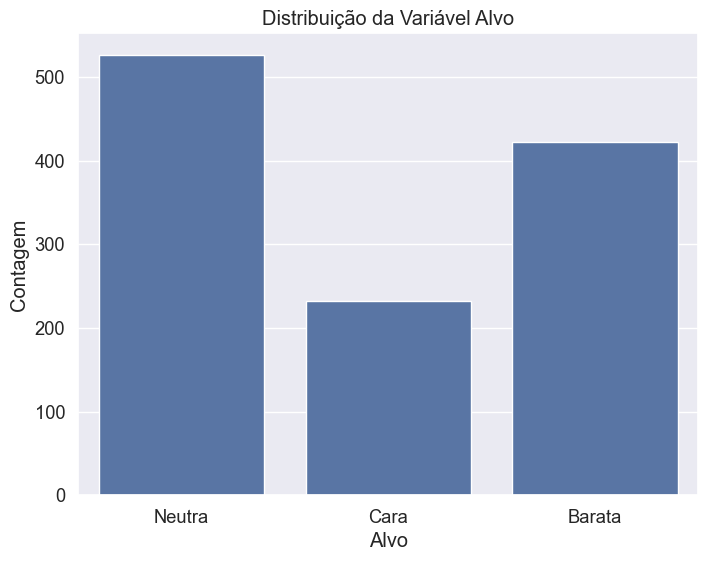

In [31]:
# Plotando gráfico de barras para a variável categórica 'Alvo'
plt.figure(figsize=(8, 6))
sns.countplot(x=df_limpo["Alvo"].map(class_names), data=df_limpo)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Alvo')
plt.ylabel('Contagem')

plt.show()

Está um pouco desbalanceado, mas optamos por não utilizar técnicas de oversampling ou undersampling para manter a representatividade do mercado real.

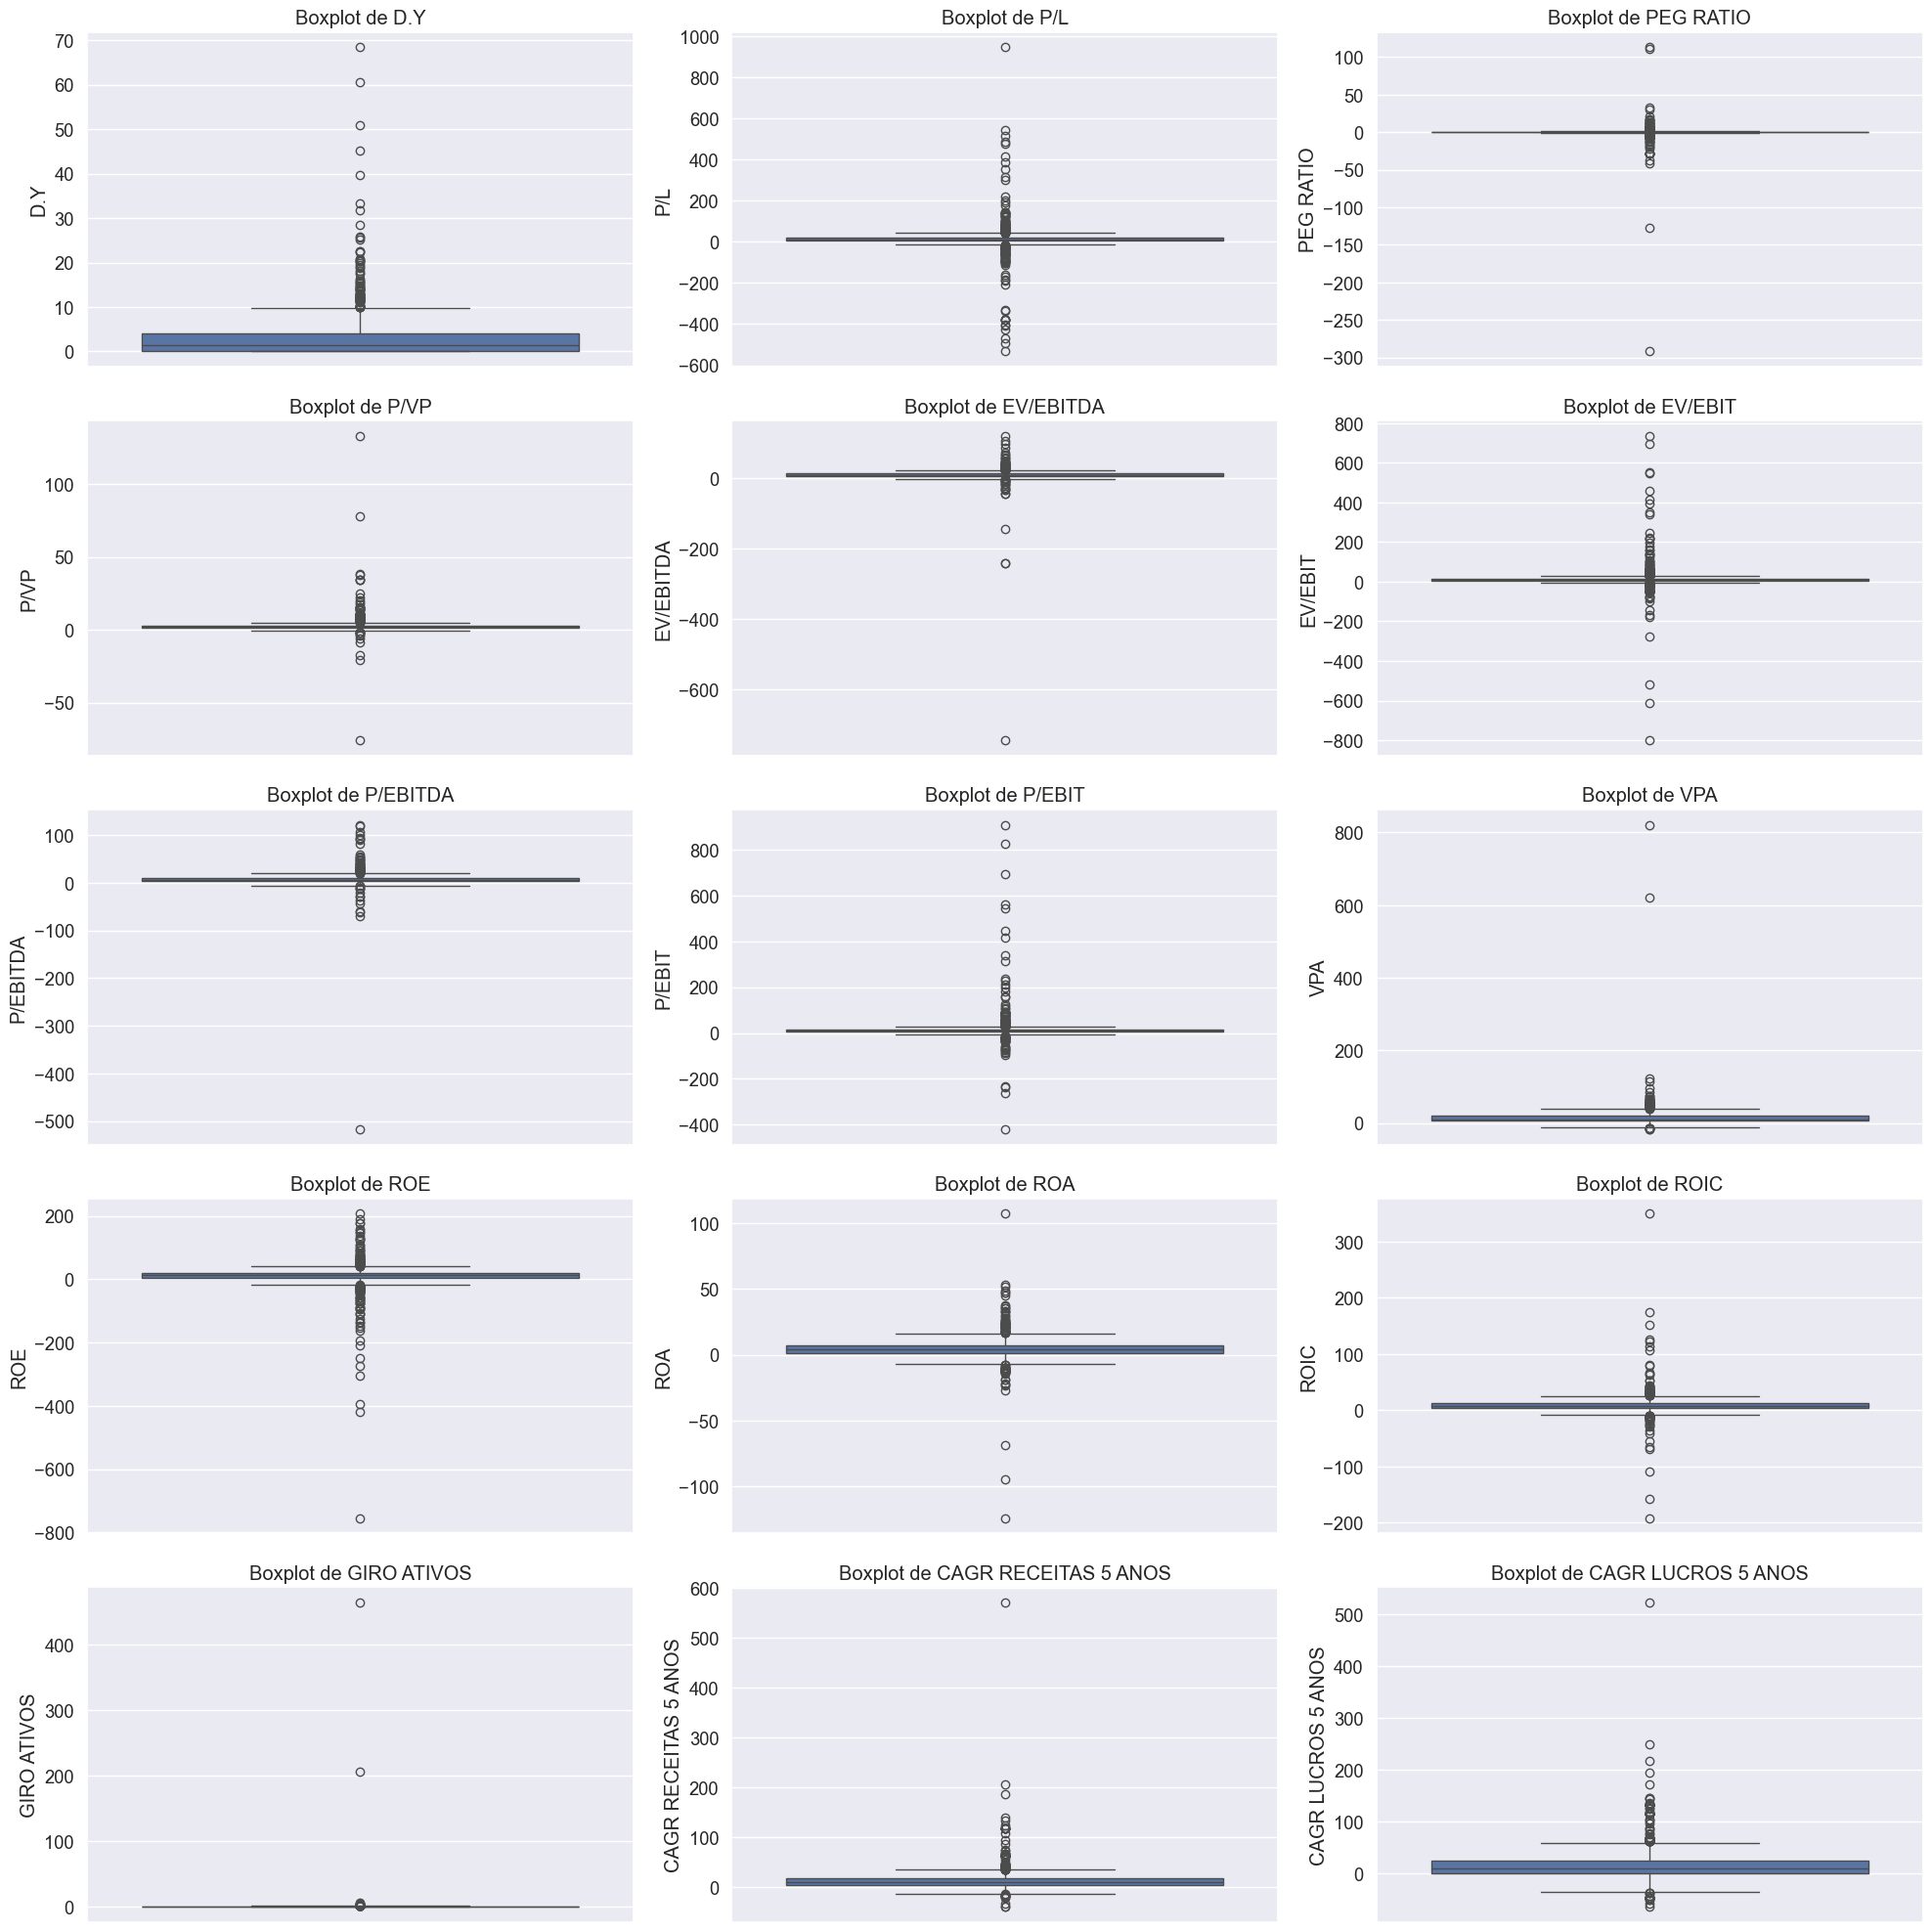

In [32]:
# Plotando boxplots para as variáveis numéricas
plt.figure(figsize=(20, 20))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(y=df[var].dropna())
    plt.title(f'Boxplot de {var}')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


Os outliers que observamos são importantes, pois indicam variações significativas entre as empresas. Essas diferenças podem ser causadas por diversos fatores do mercado ou estratégias empresariais. Portanto, optamos por mantê-los em nossa análise, pois eles são relevantes para uma avaliação abrangente e precisa, evitando distorções nos resultados.

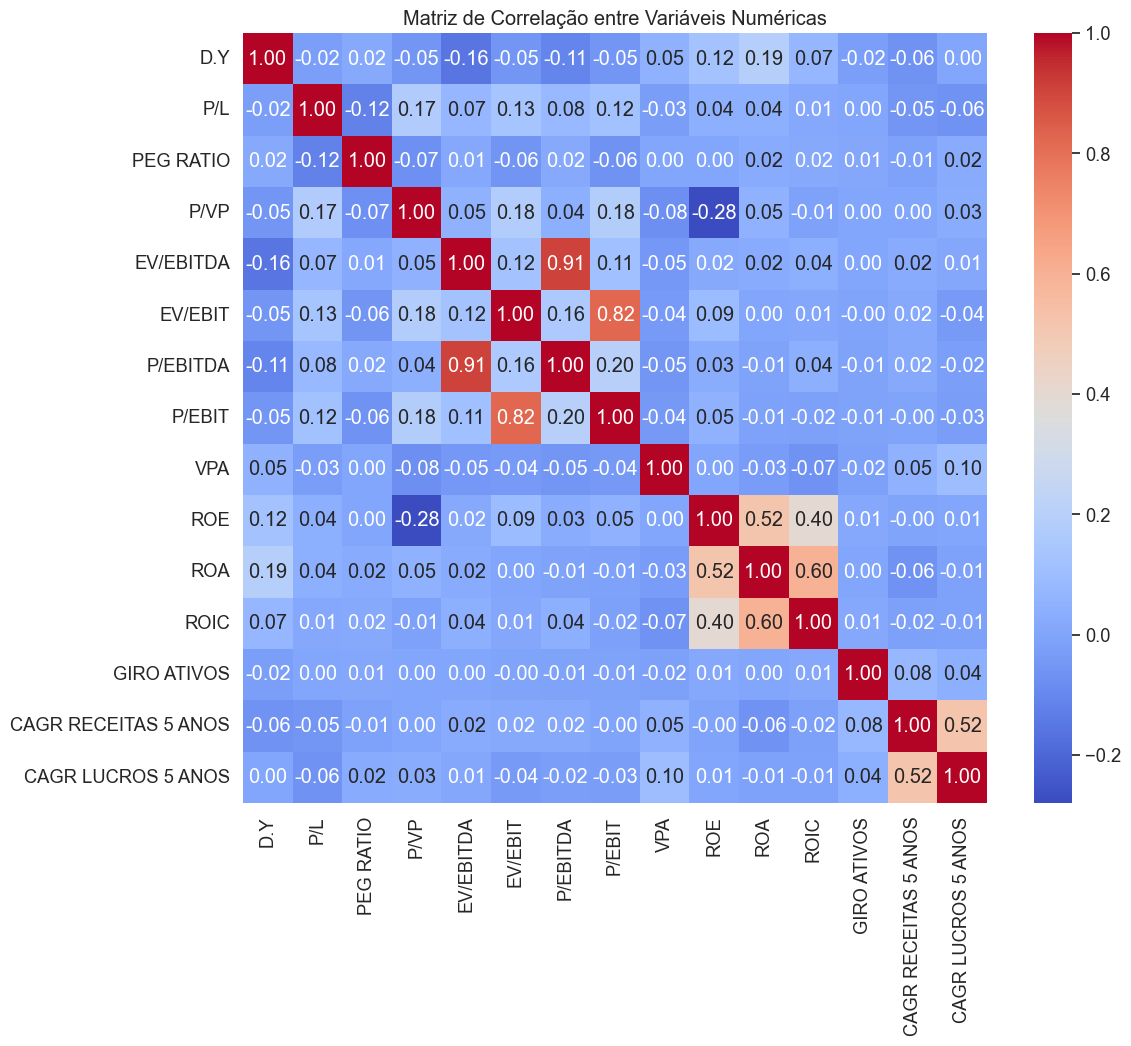

In [33]:
correlation_matrix = df[numeric_vars].corr()

# Plotando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()


Como esperado, observamos uma relação entre os indicadores de retorno sobre o patrimônio líquido (ROE), retorno sobre o capital investido (ROIC) e retorno sobre os ativos (ROA) com os indicadores de lucratividade EBITIDA, além de uma correlação com o indicador composto CAGR (CAGR RECEITAS 5 ANOS e CAGR LUCROS 5 ANOS).

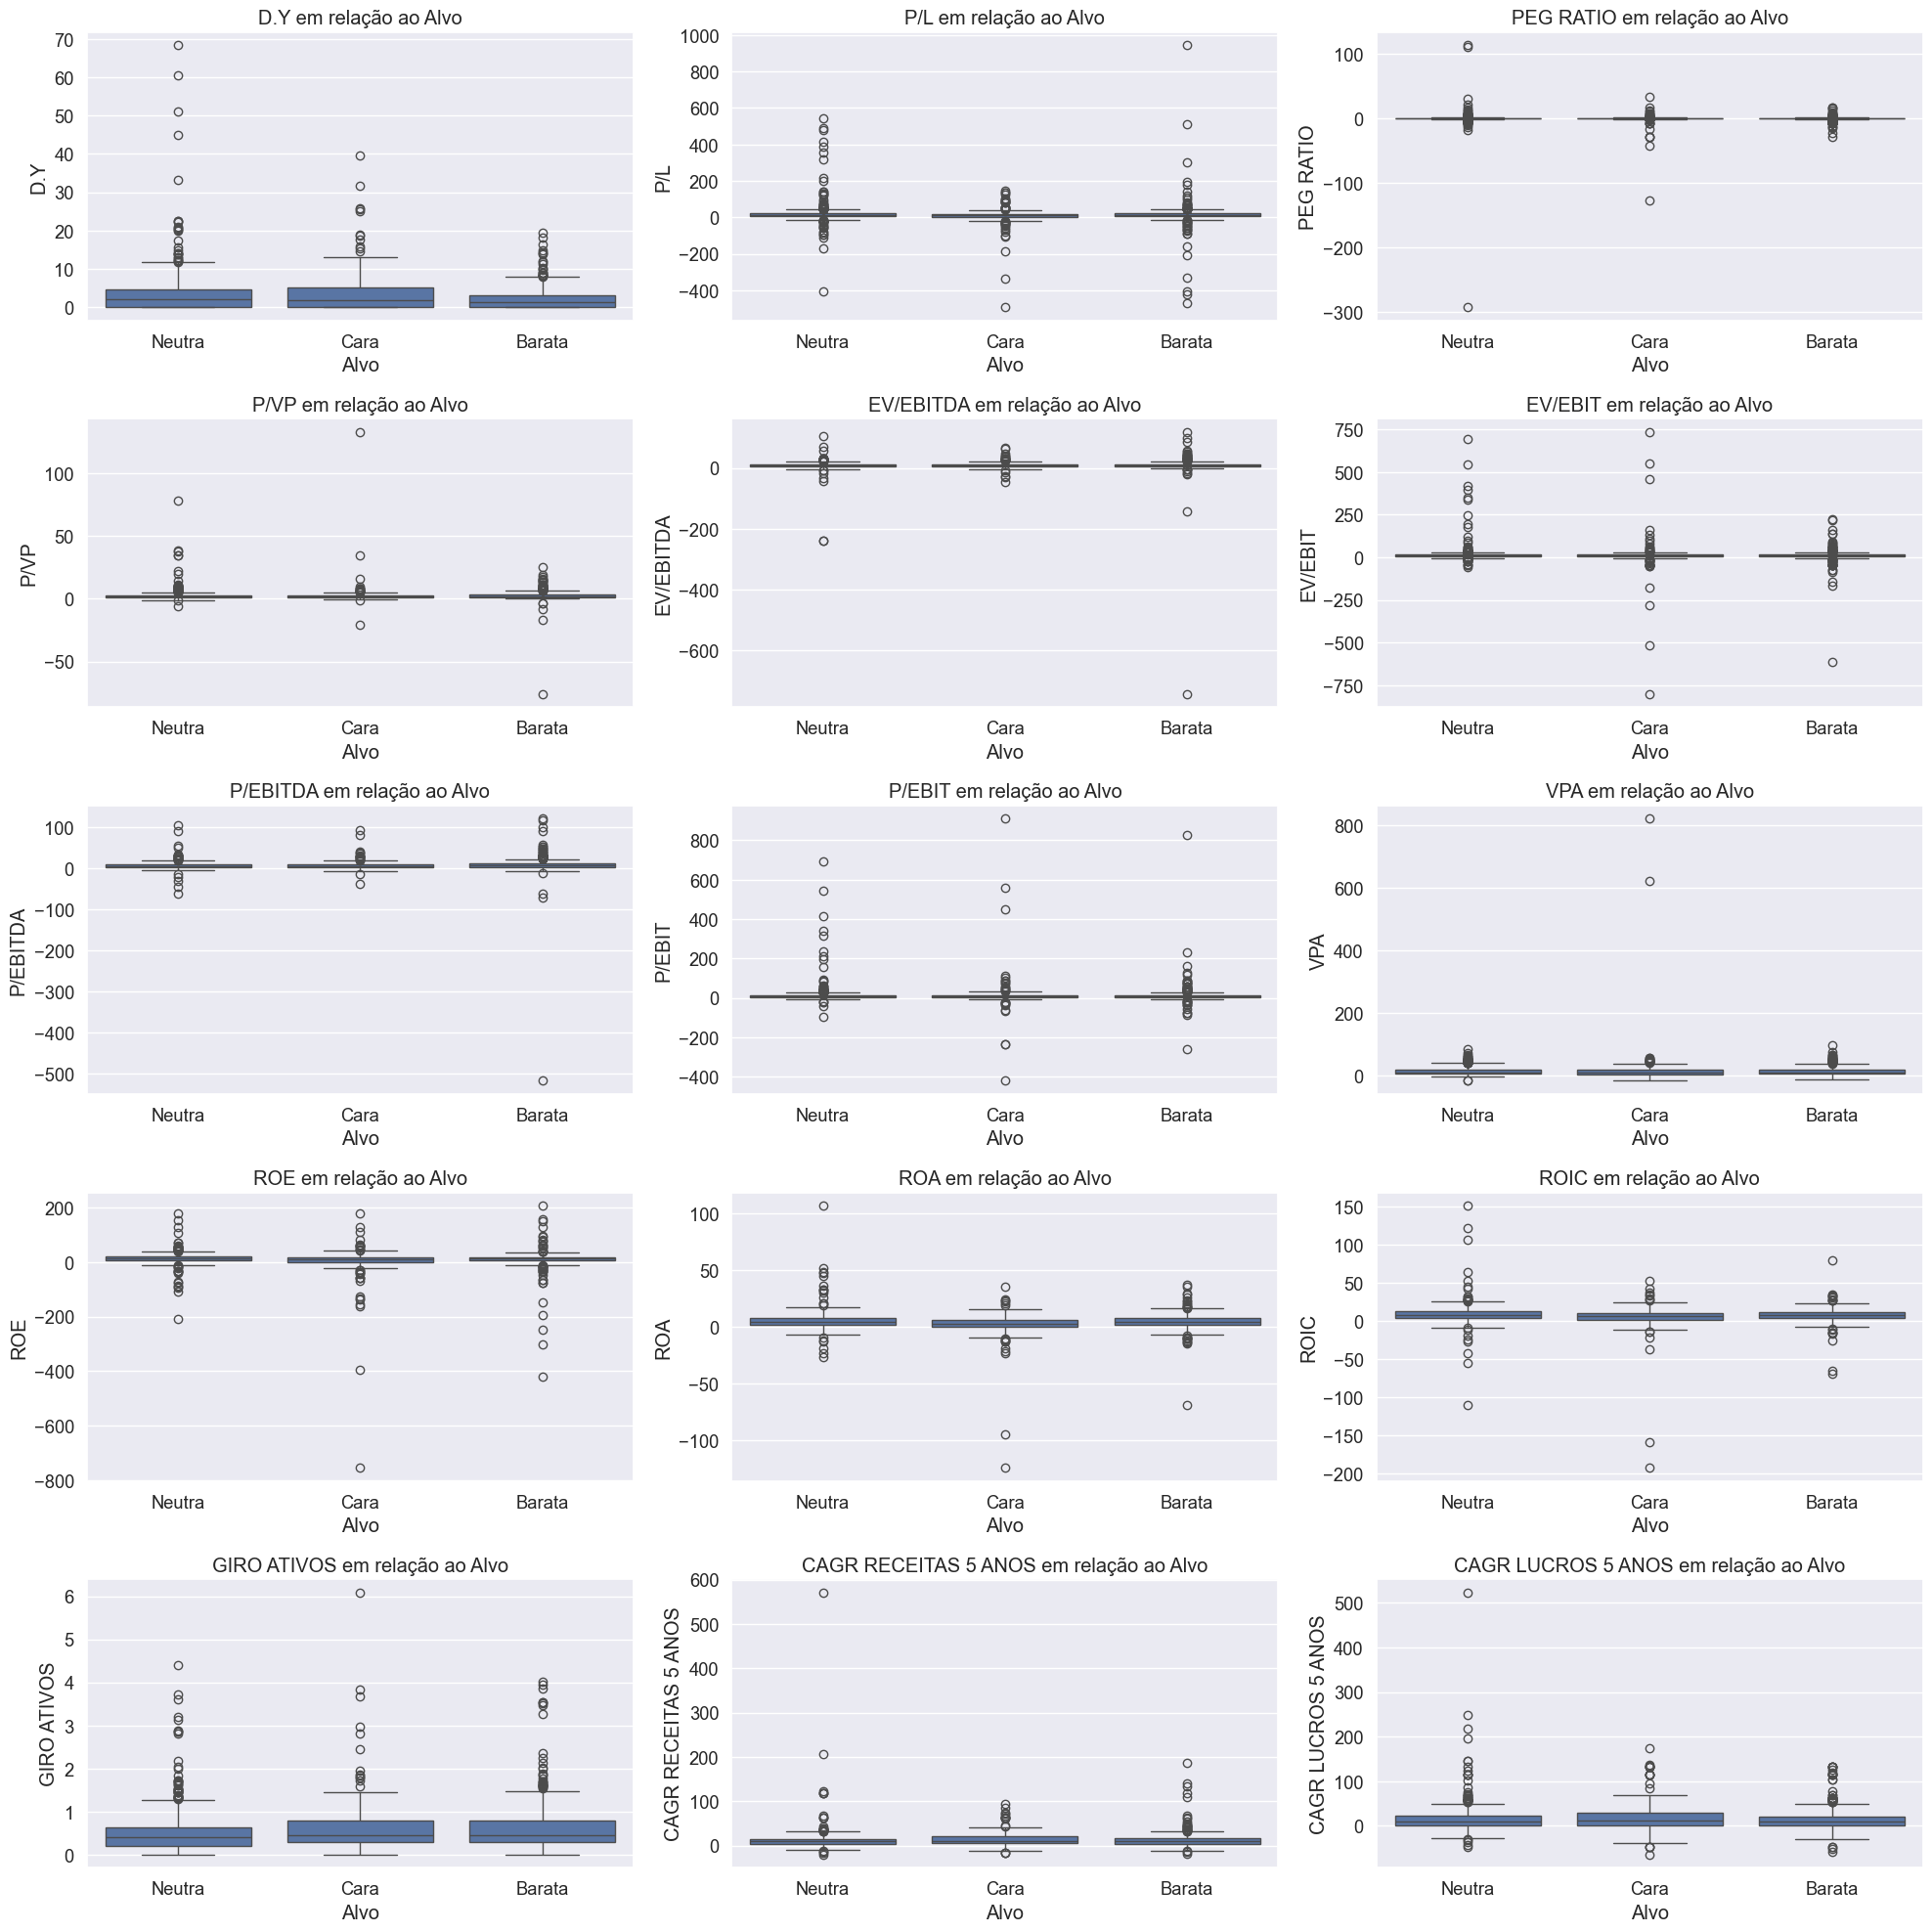

In [34]:
# Plotando os boxplots para cada variável numérica em relação ao alvo
plt.figure(figsize=(20, 20))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x=df_limpo["Alvo"].map(class_names), y=var, data=df_limpo)
    plt.title(f'{var} em relação ao Alvo')
    plt.xlabel('Alvo')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


Ao analisar os boxplots das variáveis numéricas em relação ao alvo ("Barata", "Cara", "Neutra"), observa-se que não há uma clara diferenciação entre as categorias. Os gráficos mostram que a maioria dos valores está distribuída de forma equilibrada entre as categorias, com exceção de alguns outliers que estão mais distantes da distribuição principal. Isso sugere que essas variáveis podem não ter uma relação direta ou significativa com a classificação das ações como "Barata", "Cara" ou "Neutra".

<a id="3"></a>
# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;">Escolha do algoritmo</p>

## Primeiro vamos fazer o split dos dados

Observação: não utilizamos validação cruzada devido ao nosso dataset conter poucos dados. Realizamos um teste com validação cruzada, onde a média da acurácia foi de 0.46. Portanto, é possível esperar que nosso modelo tenha um desempenho um pouco inferior em produção do que o resultado obtido neste teste.

In [35]:
# Função personalizada para calcular a raiz quadrada apenas para valores válidos
def safe_sqrt(x):
    if x >= 0:
        return np.sqrt(x)
    else:
        return -1

Fizemos um teste com um número reduzido de características, mas o resultado foi inferior ao usar o conjunto completo de features, que inclui a coluna gerada com a fórmula de Graam.

In [36]:
# Remover linhas onde a coluna alvo é nula
df_final = df_limpo.dropna(subset=['Alvo'])

# Aplicar a função personalizada para calcular a coluna 'Graam'
df_final = df_final.copy()
df_final['Graam'] = df_final.apply(lambda row: safe_sqrt(22.5 * row['LPA'] * row['VPA']), axis=1)

# Definir colunas de features e alvo
features = df_final.drop(['Ano', 'Ticker', 'PrecoAnoSeguinte', 'PrecoAnoAtual', 'Alvo'], axis=1)
#features = df_final[['P/L', 'P/VP', 'VPA', 'ROE']]
#features = df_final[['P/L', 'P/VP', 'Graam', 'ROE']]
target = df_final['Alvo']

# Dividir os dados em conjuntos de treinamento e teste (80% treinamento, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=99)

# Verificar as dimensões dos conjuntos
print("Dimensões do conjunto de treinamento (features):", X_train.shape)
print("Dimensões do conjunto de teste (features):", X_test.shape)
print("Dimensões do conjunto de treinamento (alvo):", y_train.shape)
print("Dimensões do conjunto de teste (alvo):", y_test.shape)


Dimensões do conjunto de treinamento (features): (944, 31)
Dimensões do conjunto de teste (features): (236, 31)
Dimensões do conjunto de treinamento (alvo): (944,)
Dimensões do conjunto de teste (alvo): (236,)


Agora, vamos aplicar uma técnica de escala nos nossos dados numéricos. É importante realizar essa etapa separadamente nos conjuntos de treinamento e teste para evitar vazamento de dados.

In [37]:
scaler = Normalizer()

# Normalizar os dados de treinamento e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Vamos agora treinar os modelos utilizando os seguintes algoritmos: Random Forest, Gradient Boosting, Support Vector Machines (SVM), K-Nearest Neighbors (KNN) e Naive Bayes. Escolhemos esses algoritmos por sua eficácia e versatilidade em lidar com problemas de classificação. O Random Forest e o Gradient Boosting são conhecidos por sua capacidade de lidar com dados complexos e grandes conjuntos de dados, enquanto o SVM é eficaz na separação de classes em espaços de alta dimensão. O KNN é simples de entender e implementar, sendo útil para identificar padrões em conjuntos de dados menores. Por fim, o Naive Bayes é rápido e eficiente para conjuntos de dados com muitas features. Vamos comparar os resultados obtidos por cada um desses algoritmos, selecionar o melhor e, aprimorá-lo com a utilização de hiperparâmetros.

In [38]:
# Inicializar os classificadores
rf = RandomForestClassifier(random_state=99)
gb = GradientBoostingClassifier(random_state=99)
svc = SVC(random_state=99)
knn = KNeighborsClassifier()
nb = GaussianNB()

# Treinar os classificadores
rf.fit(X_train_scaled, y_train)
gb.fit(X_train_scaled, y_train)
svc.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)
nb.fit(X_train_scaled, y_train)

# Fazer previsões nos dados de teste
rf_pred = rf.predict(X_test_scaled)
gb_pred = gb.predict(X_test_scaled)
svc_pred = svc.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)
nb_pred = nb.predict(X_test_scaled)

# Imprimir os relatórios de classificação para cada algoritmo
print("Random Forest:")
print(classification_report(y_test, rf_pred))

print("Gradient Boosting:")
print(classification_report(y_test, gb_pred))

print("Support Vector Machines:")
print(classification_report(y_test, svc_pred))

print("K-Nearest Neighbors:")
print(classification_report(y_test, knn_pred))

print("Naive Bayes:")
print(classification_report(y_test, nb_pred))


Random Forest:
              precision    recall  f1-score   support

         1.0       0.31      0.21      0.25        39
         2.0       0.51      0.49      0.50        93
         3.0       0.58      0.67      0.62       104

    accuracy                           0.53       236
   macro avg       0.47      0.46      0.46       236
weighted avg       0.51      0.53      0.51       236

Gradient Boosting:
              precision    recall  f1-score   support

         1.0       0.31      0.21      0.25        39
         2.0       0.42      0.30      0.35        93
         3.0       0.47      0.65      0.55       104

    accuracy                           0.44       236
   macro avg       0.40      0.39      0.38       236
weighted avg       0.43      0.44      0.42       236

Support Vector Machines:
              precision    recall  f1-score   support

         1.0       0.21      0.08      0.11        39
         2.0       0.53      0.26      0.35        93
         3.0    

In [39]:
# Inicializar os classificadores
rf = RandomForestClassifier(random_state=99)
gb = GradientBoostingClassifier(random_state=99)
svc = SVC(random_state=99)
knn = KNeighborsClassifier()
nb = GaussianNB()

# Treinar os classificadores
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Fazer previsões nos dados de teste
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
svc_pred = svc.predict(X_test)
knn_pred = knn.predict(X_test)
nb_pred = nb.predict(X_test)

# Imprimir os relatórios de classificação para cada algoritmo
print("Random Forest:")
print(classification_report(y_test, rf_pred))

print("Gradient Boosting:")
print(classification_report(y_test, gb_pred))

print("Support Vector Machines:")
print(classification_report(y_test, svc_pred))

print("K-Nearest Neighbors:")
print(classification_report(y_test, knn_pred))

print("Naive Bayes:")
print(classification_report(y_test, nb_pred))


Random Forest:
              precision    recall  f1-score   support

         1.0       0.25      0.18      0.21        39
         2.0       0.50      0.43      0.46        93
         3.0       0.57      0.70      0.63       104

    accuracy                           0.51       236
   macro avg       0.44      0.44      0.43       236
weighted avg       0.49      0.51      0.49       236

Gradient Boosting:
              precision    recall  f1-score   support

         1.0       0.43      0.31      0.36        39
         2.0       0.47      0.42      0.44        93
         3.0       0.54      0.65      0.59       104

    accuracy                           0.50       236
   macro avg       0.48      0.46      0.47       236
weighted avg       0.50      0.50      0.50       236

Support Vector Machines:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        39
         2.0       0.43      0.10      0.16        93
         3.0    

Não vamos utilizar a normalização dos dados, pois os resultados foram piores. Embora tenha havido uma melhora na acurácia para o Random Forest, atingindo 53%, a precisão da classe 1 foi significativamente reduzida para 0,31. Os outros algoritmos também apresentaram resultados inferiores.

### Portanto, vamos explorar mais a fundo os dados sem a normalização.

- Random Forest:

    - A precisão para a classe 1 é baixa, indicando dificuldade em identificar corretamente essa classe.
    - A acurácia geral foi de 51%, com um f1-score médio de 0.43.

- Gradient Boosting:

    - O modelo teve um desempenho melhor que o Random Forest, especialmente para as classes 1.
    - A acurácia geral foi de 50%, com um f1-score médio de 0.47.

- Support Vector Machines (SVM):

    - O SVM teve dificuldades em prever a classe 1, com uma precisão de 0%.
    - A acurácia geral foi de 45%, com um f1-score médio de 0.26.

- K-Nearest Neighbors (KNN):

    - O KNN teve um desempenho intermediário, com precisões e recalls equilibrados para as três classes.
    - A acurácia geral foi de 39%, com um f1-score médio de 0.35.

- Naive Bayes:

    - O Naive Bayes teve dificuldades em prever as classes 1 e 3, com baixa precisão e recall.
    - A acurácia geral foi de 41%, com um f1-score médio de 0.35.



Em geral, nenhum dos modelos apresentou um desempenho excepcional. O Gradient Boosting foi o melhor modelo em termos de acurácia e precisão para as três classes, mas ainda há espaço para melhorias. Vamos considerá-lo como o melhor modelo e tentar melhorar ainda mais seu desempenho ajustando os hiperparâmetros.

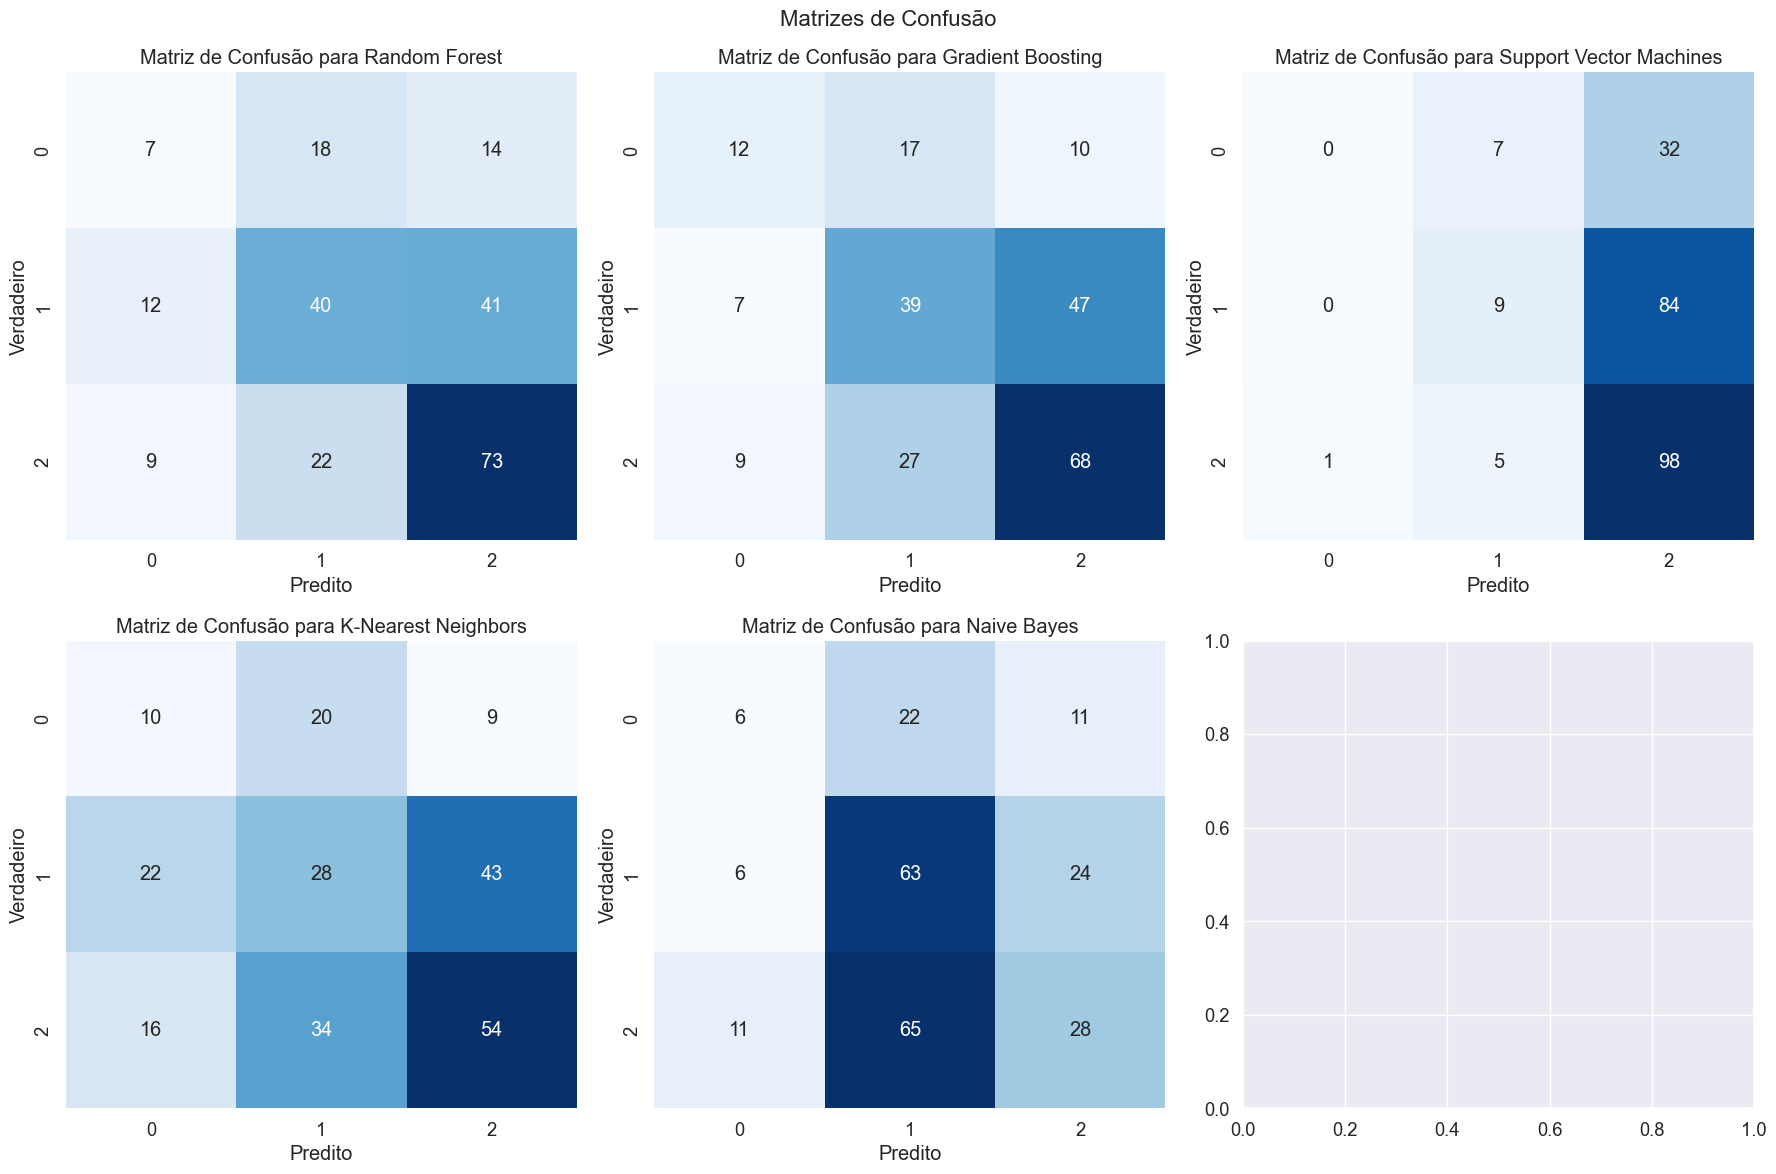

In [40]:
# Função para imprimir a matriz de confusão como um heatmap em um subplot
def plot_confusion_matrix_subplot(ax, nome_modelo, y_true, y_pred):
    matriz = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
    ax.set_title(f'Matriz de Confusão para {nome_modelo}')

# Criar uma figura com subplots agrupados a cada 3
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Imprimir as matrizes de confusão para cada modelo
plot_confusion_matrix_subplot(axs[0, 0], "Random Forest", y_test, rf_pred)
plot_confusion_matrix_subplot(axs[0, 1], "Gradient Boosting", y_test, gb_pred)
plot_confusion_matrix_subplot(axs[0, 2], "Support Vector Machines", y_test, svc_pred)
plot_confusion_matrix_subplot(axs[1, 0], "K-Nearest Neighbors", y_test, knn_pred)
plot_confusion_matrix_subplot(axs[1, 1], "Naive Bayes", y_test, nb_pred)

# Adicionar título à figura
plt.suptitle('Matrizes de Confusão', fontsize=16)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()



<a id="4"></a>
# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;">Otimização do modelo</p>

## Agora vamos utilizar os hiperparâmetros na tentativa de melhorar os resultados 

Melhor Score: 0.4586796077241937
Melhores Parâmetros: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 5}
Melhor Modelo (Gradient Boosting):
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        39
         2.0       0.57      0.09      0.15        93
         3.0       0.45      0.97      0.62       104

    accuracy                           0.46       236
   macro avg       0.34      0.35      0.26       236
weighted avg       0.43      0.46      0.33       236



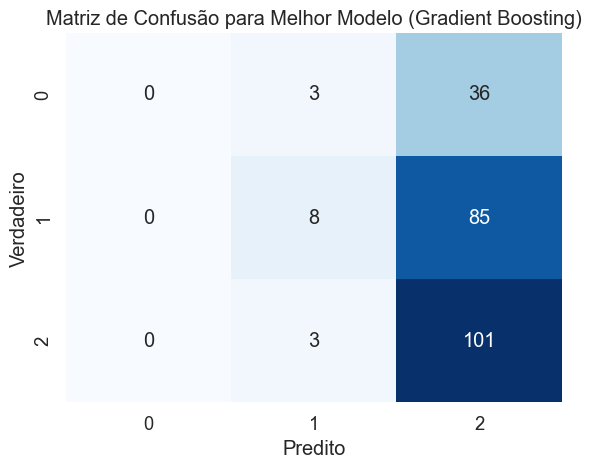

In [41]:
# Definir os parâmetros que deseja testar
param_grid = {
    'n_estimators': [1, 3, 5, 6, 7, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150],
    'learning_rate': [0.01, 0.02, 0.1, 0.5],
    'max_depth': [1, 2, 3, 4, 5, 7, 10, 15]
}

# Inicializar o classificador Gradient Boosting
gb2 = GradientBoostingClassifier(random_state=99)

# Inicializar o GridSearchCV
grid_search = GridSearchCV(estimator=gb2, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir o melhor score e os melhores parâmetros
print("Melhor Score:", grid_search.best_score_)
print("Melhores Parâmetros:", grid_search.best_params_)

# Fazer previsões nos dados de teste usando o modelo com os melhores parâmetros
best_gb = grid_search.best_estimator_
best_gb_pred = best_gb.predict(X_test)

# Imprimir o relatório de classificação do melhor modelo
print("Melhor Modelo (Gradient Boosting):")
print(classification_report(y_test, best_gb_pred))

# Imprimir a matriz de confusão do melhor modelo
plot_confusion_matrix_subplot(plt.gca(), "Melhor Modelo (Gradient Boosting)", y_test, best_gb_pred)
plt.show()

Como podemos observar, os resultados com a utilização de hiperparâmetros foram piores, tanto em termos de acurácia quanto de precisão das classes. O modelo apresentou dificuldades especialmente na identificação da classe 1.

<a id="5"></a>
# <p style="background-color:#3498DB; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#FFF; font-size:160%; text-align:center; border-radius:10px; padding:12px;"> Análise dos resultados</p>

### Testes sem hiperparâmetros:

- Random Forest:

    - A precisão para a classe 1 é baixa, indicando dificuldade em identificar corretamente essa classe.
    - A acurácia geral foi de 51%, com um f1-score médio de 0.43.

- Gradient Boosting:

    - O modelo teve um desempenho melhor que o Random Forest, especialmente para as classes 1.
    - A acurácia geral foi de 50%, com um f1-score médio de 0.47.

- Support Vector Machines (SVM):

    - O SVM teve dificuldades em prever a classe 1, com uma precisão de 0%.
    - A acurácia geral foi de 45%, com um f1-score médio de 0.26.

- K-Nearest Neighbors (KNN):

    - O KNN teve um desempenho intermediário, com precisões e recalls equilibrados para as três classes.
    - A acurácia geral foi de 39%, com um f1-score médio de 0.35.

- Naive Bayes:

    - O Naive Bayes teve dificuldades em prever as classes 1 e 3, com baixa precisão e recall.
    - A acurácia geral foi de 41%, com um f1-score médio de 0.35.



Em geral, nenhum dos modelos apresentou um desempenho excepcional. O Gradient Boosting foi o melhor modelo em termos de acurácia e precisão para as três classes, mas ainda há espaço para melhorias. Vamos considerá-lo como o melhor modelo e tentar melhorar ainda mais seu desempenho ajustando os hiperparâmetros.

### Testes com hiperparâmetros:

- Teve uma acurácia de 46%.
- A classe 1 teve uma precisão de 0%, recall de 0% e f1-score de 0%.
- A classe 2 teve uma precisão de 57%, recall de 9% e f1-score de 15%.
- A classe 3 teve uma precisão de 45%, recall de 97% e f1-score de 62%.


Os resultados com hiperparâmetros mostraram uma precisão significativamente menor para a classe 1, chegando a zero. Isso indica que o modelo com hiperparâmetros teve dificuldades em prever corretamente a classe 1, o que pode ser um indicativo de overfitting.

# Conclusão 

Com uma acurácia próxima de 50% (considerando três classes, o que para o mercado financeiro não é considerado tão ruim), e com a seleção de ativos realizada por um analista com expertise, podemos afirmar que esse método é interessante e merece ser explorado. Embora esperasse uma precisão um pouco maior, não consegui melhorar os resultados. Talvez se tivéssemos mais dados disponíveis, como dados mensais em vez de anuais, poderíamos obter melhores resultados. No entanto, não consegui encontrar esses dados gratuitamente, acredito que apenas uma API paga ofereceria essa possibilidade.

O método atual pode ser explorado com mais ênfase na classe "Barata", visando exclusivamente à compra de ativos. No entanto, o projeto atual propõe uma abordagem que envolve tanto a compra quanto a venda de ativos, exigindo um equilíbrio entre as três classes ("Cara", "Barata" e "Neutra"). Portanto, não podemos priorizar apenas uma classe neste contexto, mas sim considerar o cenário completo para uma análise mais abrangente e equilibrada das decisões de investimento.

* É importante ressaltar que, como o preço do ano atual e do seguinte foi considerado como a média, esse percentual de acerto pode variar significativamente no teste real, pois depende muito do momento da compra ou da venda da ação.

## Exportando o melhor modelo treinado para posteriormente fazer o deploy

In [42]:
# Verificar se a pasta 'data/model' existe, se não existir, criar
model_dir = '../data/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Exportar os modelos treinados
dump(gb, os.path.join(model_dir, 'gradient_boosting_model.joblib'))

['../data/models\\gradient_boosting_model.joblib']

# Aplicação em produção

A aplicação em produção foi feita com Streamlit. O objetivo da aplicação é permitir que o usuário obtenha uma análise rápida sobre se uma ação está cara, neutra ou barata com base em indicadores financeiros.

Para isso, o usuário digita o ticker da ação desejada e a aplicação busca os dados dos indicadores financeiros em um arquivo CSV baixado do site Status Invest, que contém os indicadores atualizados de todas as ações. Em seguida, a aplicação utiliza o nosso modelo de machine learning previamente treinado para fazer a análise e retorna a classificação da ação.

Para acessar e ver como está em produção, [clique aqui](https://investlink.streamlit.app/).